In [1]:
from __future__ import print_function
from gensim.models import Word2Vec 
#Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community.

import jieba #“结巴”中文分词：做最好的 Python 中文分词组件
import numpy as np
from sklearn.manifold import TSNE
from copy import deepcopy

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
K.set_session(tf.compat.v1.Session(config=config))


%matplotlib inline

Using TensorFlow backend.


# 1. Word Embedding using Word2Vec and Visualization

In [7]:
def load_text(path):
    with open(path, 'r', encoding='utf-8') as f:
        text = f.read()

    
    return text

In [8]:
text = load_text('./data/hongloumeng.txt')
print('corpus length:', len(text))

corpus length: 855523


In [13]:
def cut_sentence(text):
    start = 0
    i = 0
    sentences = []

    #punt_list = ',.!?:;~，。！？：；～'.decode('utf8')
    #punt_list = ',.!?:;~，．。！？：；～'.decode('utf-8')
    punt_list = '.!?~． 。！？～\n'
    for word in text:
        if word in punt_list and token not in punt_list: #检查标点符号下一个字符是否还是标点
            sentences.append(text[start:i+1])
            start = i+1
            i += 1
        else:
            i += 1
            token = list(text[start:i+2]).pop() # 取下一个字符
    if start < len(text):
        sentences.append(text[start:])
    return sentences

## 1.1分词

In [15]:
sentences = cut_sentence(text)
sentences[:10]

['《红楼梦》曹雪芹\n\n',
 '严正声明：本书为丫丫小说网(www.',
 'shuyaya.',
 'com)的用户上传至其在本站的存储空间，本站只提供TXT全集电子书存储服务以及免费下载服务，以下作品内容之版权与本站无任何关系。\n',
 '在线阅读：http://www.',
 'shuyaya.',
 'com/read/2034/\n',
 '--------------------------------------------------\n\n',
 '第一回  ',
 '甄士隐梦幻识通灵\u3000贾雨村风尘怀闺秀\n\n    ']

In [16]:
tokenized_sentences = []
for sentence in sentences:
    tokenized_sentences.append([w for w in jieba.cut(sentence)])

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\haiha\AppData\Local\Temp\jieba.cache
Loading model cost 0.688 seconds.
Prefix dict has been built successfully.


In [17]:
for w in tokenized_sentences[300]:
    print(w)

"
封肃
忙
陪笑
道
：
“
小人
姓
封
，
并
不姓
甄
．


# 1.2 Word2Vec

#### build the word2vec model for a given token list

In [18]:
model = Word2Vec(tokenized_sentences, size=50) 
#for now, we just define the size to 50, which means each token will be vectorized to vector with length of 50

In [19]:
vocab = model.wv.vocab #a dict storing unique tokens in the model

In [23]:
print(list(vocab.keys())[1])

红楼梦


In [24]:
model.save('word2vec_model_hongloumeng.model.bin')

#### Find most_similar words

In [27]:
model.wv.most_similar_cosmul?

In [25]:
for word, sim in model.wv.most_similar_cosmul(positive=[u'宝玉', u'黛玉'], negative=[u'宝钗']):
    print(word, sim)

贾琏 0.9087133407592773
凤姐 0.9067167639732361
紫鹃 0.9037010669708252
林黛玉 0.9013649225234985
薛姨妈 0.895914614200592
鸳鸯 0.8918719291687012
香菱 0.886788010597229
雨村 0.8822209239006042
晴雯 0.8805127739906311
赵姨娘 0.8802212476730347


Explanation of positive and negative parameters in model.wv.most_similar_cosmul:

 >  model.wv.most_similar(positive=[‘woman’, ‘king’], negative=[‘man’], topn=1)[0]

Here, we are adding king and woman (they are positive parameters), and subtracting man (it is a negative parameter), and choosing only the first value in the tuple.
-> In plain language: The above code means:  we are searching for **the word most similar to Woman and King, but far away from Man.**

-> (u’queen’)

And voila! As we expected, Queen is the closest word vector when we search for **the word most similar to Woman and King, but far away from man.**

<img src="Word2Vec_Find_Similar_Word_Example.png">

Therefore, the model.wv.most_similar_cosmul(positive=[u'宝玉', u'黛玉'], negative=[u'宝钗']) code above means:
- Find the most similar words that is close to '宝玉' and '黛玉', but far from '宝钗'

#### Find similarity between two words

In [39]:
model.wv.similarity(u'宝玉', u'黛玉')

0.75354844

In [38]:
model.wv.similarity(u'宝玉', u'宝钗')

0.8549028

Other Resources for word to vector:
- Facebook: fasttext
- Google: word2vec

## 1.3可视化

Please note:
Because visualization cannot visualize chinese character easily, therefore below used a workaround to just use index to represent the word in graph

In [40]:
def plot_with_labels(embedded_vectors, labels):

    assert embedded_vectors.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize = (18, 18))
    for i, label in enumerate(labels):
        x, y = embedded_vectors[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy = (x, y), xytext = (5, 2), textcoords = 'offset points',ha = 'right',va = 'bottom')
    plt.show()

In [42]:
hongloumeng_embedding = Word2Vec.load('word2vec_model_hongloumeng.model.bin')

In [43]:
type(hongloumeng_embedding)

gensim.models.word2vec.Word2Vec

In [45]:
#build nparray from loaded word2vec model
word_embedding = np.zeros((len(vocab) + 1, 50))
word_mapping = {}
for i, word in enumerate(hongloumeng_embedding.wv.vocab.keys()):
    word_embedding[i + 1] = hongloumeng_embedding.wv[word]
    word_mapping[word] = i + 1

In [47]:
index2word = dict((v, k) for k, v in word_mapping.items())

In [48]:
n_words_to_show = 300
start_index = 1000
tsne = TSNE(perplexity = 30, n_components = 2, init = 'pca', n_iter = 500) #TSNE: reduce dim to visualization (e.g. here we reduced to 2-dim graph) 
reduced_word_vectors = tsne.fit_transform(word_embedding[start_index:start_index+n_words_to_show+1, :])
labels = [i for i in range(start_index, start_index+n_words_to_show+1)]

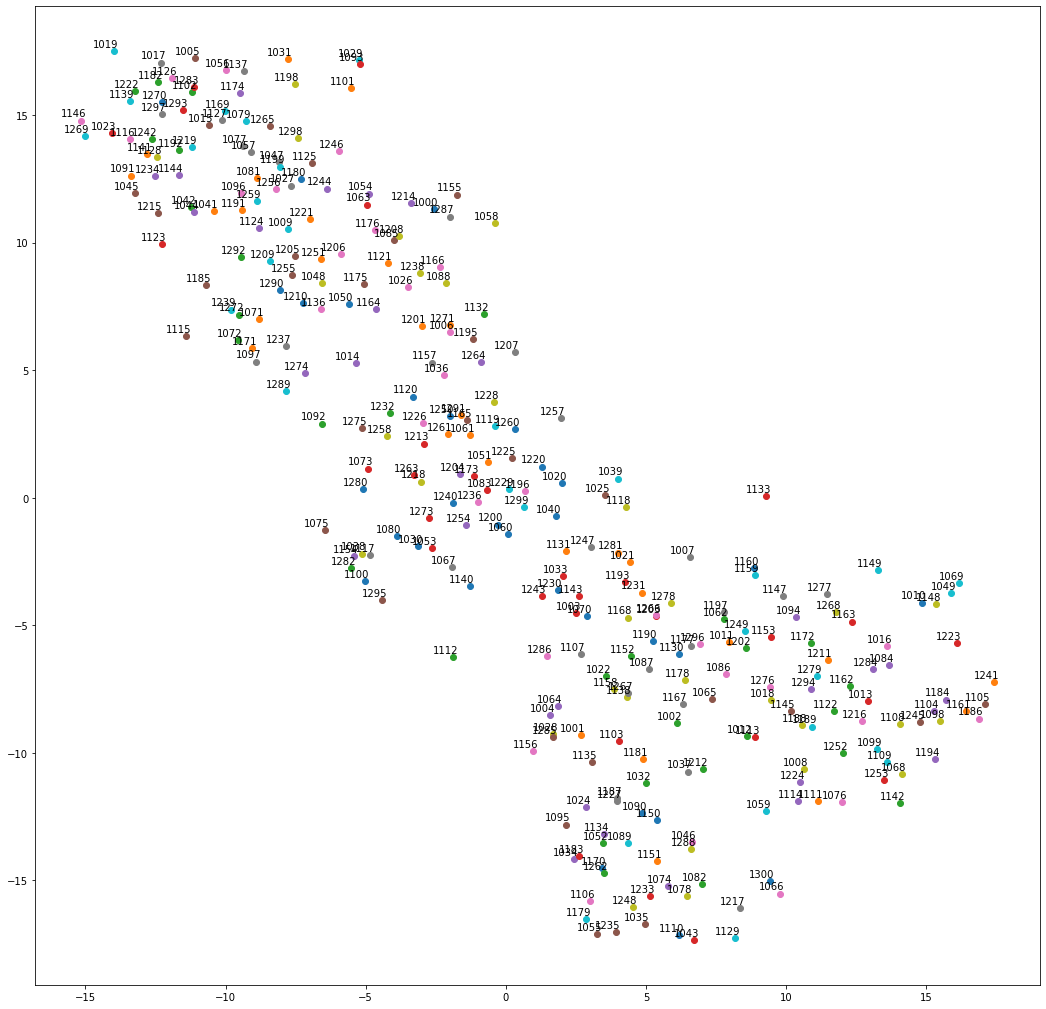

In [49]:
plot_with_labels(reduced_word_vectors, labels)

# 2. RNN Language Model for Text Generation of Hongloumeng.txt

In [50]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Embedding
from keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split

import itertools
from collections import Counter

## 2.1 红楼梦的语言模型

In [51]:
word_counts = Counter(itertools.chain(*tokenized_sentences))

In [53]:
max_vocab = 20000 #define the max vocab in scope is 20000 (first 20000 most frequent vocab); any extra is truncated
vocabulary = [x[0] for x in word_counts.most_common(max_vocab)]
vocabulary = list(sorted(vocabulary))
word2index = {x : i + 1 for i, x in enumerate(index2word)}
index2word = dict((v, k) for k, v in word2index.items())

In [54]:
test_size = int(len(tokenized_sentences)*0.3)

In [55]:
#We want to build a model to predict (i+1) th word using all words from first to ith word.

x = [] #Input is a sentence: first word to ith word
y = [] #output label is a single word (i+1)th word.)
maxlen = 50
for s in tokenized_sentences[:-test_size]:
    tmp = []
    for i in range(min(len(s)-1, maxlen)):
        tmp.append(word2index[s[i]] if s[i] in word2index else 0)
        x.append(deepcopy(tmp))
        y.append(word2index[s[i+1]] if s[i+1] in word2index else 0)

In [57]:
assert len(x) == len(y)

In [58]:
x = pad_sequences(x, maxlen=maxlen, padding='pre') #padding to the same size

In [59]:
x.shape

(394066, 50)

In [60]:
vocab_size = len(word2index)+1

In [61]:
y = np.array(y, dtype=np.int64)

In [62]:
#Output label: One-hot encoding
Y_onehot = np.zeros((y.shape[0], vocab_size), dtype=np.bool)
for idx in range(y.shape[0]):
    Y_onehot[idx, y[idx]] = 1

In [63]:
train_x, valid_x, train_y, valid_y = train_test_split(x, Y_onehot, test_size=0.3, random_state=0)

In [64]:
#build Model:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=maxlen)) #embedding layer to get embedding vector: each input is converted to a embedding vector
model.add(LSTM(50))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))

In [65]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 10)            73900     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dense_1 (Dense)              (None, 7390)              376890    
_________________________________________________________________
activation_1 (Activation)    (None, 7390)              0         
Total params: 462,990
Trainable params: 462,990
Non-trainable params: 0
_________________________________________________________________


In [66]:
rmsprop = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

In [67]:
model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=1, verbose=True)

D:\Program_Data\Anaconda3\envs\py37tf_gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 275846 samples, validate on 118220 samples
Epoch 1/1
275846/275846 [==============================] - 296s 1ms/step - loss: 0.0036 - accuracy: 0.9999 - val_loss: 0.0000e+00 - val_accuracy: 1.0000.024 - ETA: 3:50 - loss: 0.0235  - ETA: 3:49 - loss: 0.0232 - accu - ETA: 3:49 - loss: 0.0230 - accura - ETA: 3:49 - loss: 0.0228 - accuracy: 0.99 - ETA: 3: - ETA: 3:47 - ETA: 3:46 - loss: 0.0217 - ac - ETA: 2:21 - loss: 0.0 - E - ETA: 2:19 - loss: 0.0076  - ETA: 2:19 - loss: 0.0076 - accura - ETA: 2:18 - los - ETA: 2:17 - loss: 0.0075 - accuracy: 0.99 - ETA: 2:17 - loss: 0.0075 - accuracy:  - ETA: 2:17 - loss: 0.007 - ETA: 2:17 - loss: 0.0074 - accu - ETA: 2:15 - loss: 0.0073 - accuracy - ETA: 2:15 - - ETA: 2: - ETA - ETA: 1:51 - loss: 0.0062 - accu - ETA:  - ETA: 1: - ETA: 1:46 - loss: 0.0060 - accu - ETA: 1:46 - ETA: 1:42 - loss: 0.0059 - ac - ETA: 1:41 - loss: 0.0058 - accu - ETA: 1:41 - loss: 0.0058 - accura - ETA: 1:41 - loss: 0.0058  - ETA: 1:40 - loss: 0.0058 - accura - ETA: 1:

Note: A good validation loss value is below 2, close to 1 or below 1

## 2.2 测试语言模型

In [68]:
def compute_total_words(sentences):
    
    return np.sum([len(s) for s in sentences])

In [69]:
n_words_in_test = compute_total_words(tokenized_sentences[-test_size:])

In [70]:
n_words_in_test

175842

In [71]:
def compute_sentence_log_prob(model, sentence):
    test_x = []
    test_y = []
    tmp = []
    for i in range(len(sentence)-1):
        tmp.append(word_mapping[sentence[i]] if sentence[i] in word_mapping else 0)
        test_x.append(deepcopy(tmp))
        test_y.append(word_mapping[sentence[i+1]] if sentence[i+1] in word_mapping else 0)
    test_x = pad_sequences(test_x, maxlen=maxlen, padding='pre')
    test_y = np.array(test_y)
    test_y_pred = model.predict(test_x)
    probs = test_y_pred[(np.arange(test_x.shape[0]), test_y)]
    return np.sum(np.log2(probs))

In [72]:
compute_sentence_log_prob(model, tokenized_sentences[-3])

-707.0357

In [73]:
sum_log_prob = 0.0
for s in tokenized_sentences[-test_size:]:
    if len(s) <= 1:
        continue
    log_prob_s = compute_sentence_log_prob(model, s)
    sum_log_prob += log_prob_s
perplexity = 2**(-sum_log_prob/n_words_in_test)

In [74]:
perplexity

4902040839.801971

Note: The perplexity shows how much varied the predicted distribution for the next word is. When a language model represents the dataset well, it should show a high probability only for the correct next word, so that the entropy should be high.

**smaller perplexity means better model.**

So the model above is not good at all after epoch=1 training

# 3. RNN for POS tagging

For this tutorial, we use treebank corpus (语料库） from nltk to finish training

## 3.1 Load data

In [75]:
from nltk.corpus import treebank #a test dataset for this tutorial
from keras.layers import TimeDistributed, Dropout

In [78]:
import nltk
# nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\haiha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\treebank.zip.


True

In [79]:
train_data = treebank.tagged_sents()

print(train_data[0])

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


In [80]:
#Build 2 dicts (one for word, one for label), to convert unique word or label to integer index
word_mapping = {}
label_mapping = {}
i, j = 1, 1
for s in train_data:
    for t in s:
        if t[0] not in word_mapping:
            word_mapping[t[0]] = i
            i += 1
        if t[1] not in label_mapping:
            label_mapping[t[1]] = j
            j += 1

In [81]:
word_mapping

{'Pierre': 1,
 'Vinken': 2,
 ',': 3,
 '61': 4,
 'years': 5,
 'old': 6,
 'will': 7,
 'join': 8,
 'the': 9,
 'board': 10,
 'as': 11,
 'a': 12,
 'nonexecutive': 13,
 'director': 14,
 'Nov.': 15,
 '29': 16,
 '.': 17,
 'Mr.': 18,
 'is': 19,
 'chairman': 20,
 'of': 21,
 'Elsevier': 22,
 'N.V.': 23,
 'Dutch': 24,
 'publishing': 25,
 'group': 26,
 'Rudolph': 27,
 'Agnew': 28,
 '55': 29,
 'and': 30,
 'former': 31,
 'Consolidated': 32,
 'Gold': 33,
 'Fields': 34,
 'PLC': 35,
 'was': 36,
 'named': 37,
 '*-1': 38,
 'this': 39,
 'British': 40,
 'industrial': 41,
 'conglomerate': 42,
 'A': 43,
 'form': 44,
 'asbestos': 45,
 'once': 46,
 'used': 47,
 '*': 48,
 'to': 49,
 'make': 50,
 'Kent': 51,
 'cigarette': 52,
 'filters': 53,
 'has': 54,
 'caused': 55,
 'high': 56,
 'percentage': 57,
 'cancer': 58,
 'deaths': 59,
 'among': 60,
 'workers': 61,
 'exposed': 62,
 'it': 63,
 'more': 64,
 'than': 65,
 '30': 66,
 'ago': 67,
 'researchers': 68,
 'reported': 69,
 '0': 70,
 '*T*-1': 71,
 'The': 72,
 'fiber'

In [82]:
label_mapping

{'NNP': 1,
 ',': 2,
 'CD': 3,
 'NNS': 4,
 'JJ': 5,
 'MD': 6,
 'VB': 7,
 'DT': 8,
 'NN': 9,
 'IN': 10,
 '.': 11,
 'VBZ': 12,
 'VBG': 13,
 'CC': 14,
 'VBD': 15,
 'VBN': 16,
 '-NONE-': 17,
 'RB': 18,
 'TO': 19,
 'PRP': 20,
 'RBR': 21,
 'WDT': 22,
 'VBP': 23,
 'RP': 24,
 'PRP$': 25,
 'JJS': 26,
 'POS': 27,
 '``': 28,
 'EX': 29,
 "''": 30,
 'WP': 31,
 ':': 32,
 'JJR': 33,
 'WRB': 34,
 '$': 35,
 'NNPS': 36,
 'WP$': 37,
 '-LRB-': 38,
 '-RRB-': 39,
 'PDT': 40,
 'RBS': 41,
 'FW': 42,
 'UH': 43,
 'SYM': 44,
 'LS': 45,
 '#': 46}

In [83]:
vocab_size = len(word_mapping) + 1
label_size = len(label_mapping) + 1

In [84]:
x = []
y = []
maxlen = -np.inf
for s in train_data:
    maxlen = max(len(s), maxlen)
    x.append([word_mapping[t[0]] for t in s])
    y.append([label_mapping[t[1]] for t in s])

In [85]:
x = pad_sequences(x, maxlen=maxlen, padding='pre')
y = pad_sequences(y, maxlen=maxlen, padding='pre')

In [86]:
y.shape

(3914, 271)

In [87]:
#one hot encoding to Y label
Y_onehot = np.zeros((y.shape[0], maxlen, label_size), dtype=np.bool)
for i in range(y.shape[0]):
    for j in range(maxlen):
        Y_onehot[i, j, y[i, j]] = 1

In [88]:
#build model:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=maxlen))
model.add(LSTM(50, return_sequences=True))
#Here we need return_sequences=True, because we need hidden state from each token in sequence.
    #otherwise,if return_sequences=False -> LSTM only take hidden state (h) from last word in sequence 
    #see graph below for visual explanation

model.add(TimeDistributed(Dense(64, activation='relu')))
#Using TimeDistributed layer to copy the operation in each word of a sequence, a max_len times.
    #see graph below for visual explanation

model.add(TimeDistributed(Dropout(0.2)))
model.add(TimeDistributed(Dense(label_size, activation='softmax')))

<img src='RNNforPosTag.png'>

In [89]:
rmsprop = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

In [90]:
train_x, valid_x, train_y, valid_y = train_test_split(x, Y_onehot, test_size=0.3, random_state=0)

In [91]:
model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=1, verbose=True)

D:\Program_Data\Anaconda3\envs\py37tf_gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2739 samples, validate on 1175 samples
Epoch 1/1
2739/2739 [==============================] - 18s 7ms/step - loss: 0.2950 - accuracy: 0.9334 - val_loss: 0.0602 - val_accuracy: 0.9835


#### Test Model:

In [92]:
test_s = "Today is a good day .".split()

In [93]:
test_x = pad_sequences([[word_mapping[w] for w in test_s]], maxlen=maxlen, padding='pre')

In [94]:
test_y_pred = model.predict(test_x)

In [96]:
index2label = dict((v, k) for k, v in label_mapping.items())

In [97]:
pred_label = []
for idx in np.argmax(test_y_pred, axis=2)[0]:
    if idx > 0:
        pred_label.append(index2label[idx])

In [99]:
print(test_s)
print(pred_label)

['Today', 'is', 'a', 'good', 'day', '.']
['NN', 'VBZ', 'DT', 'JJ', 'NN', '.']
